In [1]:
import json
import numpy as np
import tensorflow as tf
from itertools import product
from mleam.data_prep import descriptor_dataset_from_json
from mlpot.descriptors import DescriptorSet

2024-08-30 18:48:30.144027: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 18:48:30.145775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 18:48:30.169616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 18:48:30.169646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 18:48:30.169674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
etas = [0.001, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]
cutoffs = {
    ("Ni", "Ni"): 5.57,
    ("Ni", "Pt"): 5.887567,
    ("Pt", "Ni"): 5.887567,
    ("Pt", "Pt"): 6.2050886,
}


with DescriptorSet(["Ni", "Pt"]) as descriptor_set:
    for eta in etas:
        for ti, tj in product(descriptor_set.atomtypes, repeat=2):
            descriptor_set.add_two_body_descriptor(
                ti,
                tj,
                "BehlerG2",
                [eta, 0.0],
                cuttype="polynomial",
                cutoff=cutoffs[(ti, tj)],
            )

    dataset = descriptor_dataset_from_json(
        "../data/train_data.json",
        descriptor_set,
        forces=False,
    )

    input, _ = next(iter(dataset))

Gs_Ni = np.zeros(
    (tf.reduce_sum(tf.cast(input["types"] == 0, dtype=tf.int32)).numpy(), 14)
)
Gs_Pt = np.zeros(
    (tf.reduce_sum(tf.cast(input["types"] == 1, dtype=tf.int32)).numpy(), 14)
)

i_Ni = 0
i_Pt = 0
for types, Gs in zip(input["types"], input["Gs"]):
    for ti, Gi in zip(types, Gs):
        if ti == 0:
            Gs_Ni[i_Ni] = Gi
            i_Ni += 1
        elif ti == 1:
            Gs_Pt[i_Pt] = Gi
            i_Pt += 1
        if i_Ni % 10000 == 1:
            print(i_Ni)

Constructor called with 2 atom types


/home/ralf/Development/miniconda3/envs/mleam/lib/python3.10/site-packages/mlpot-0.2-py3.10.egg/mlpot/descriptors/descriptorset.py:106: UserWarning: The Behler atom-centered symmetry functions have been renamed and now follow the convention of J. Behler, JCP 134 074106
  warn('The Behler atom-centered symmetry functions have been renamed ' +


1
10001
20001
30001
40001
50001
60001
70001


In [3]:
norms = dict(
    Gs_min=dict(Ni=Gs_Ni.min(axis=0).tolist(), Pt=Gs_Pt.min(axis=0).tolist()),
    Gs_max=dict(Ni=Gs_Ni.max(axis=0).tolist(), Pt=Gs_Pt.max(axis=0).tolist()),
)

with open("descriptor_norms.json", "w") as fout:
    json.dump(norms, fout)

# Reproduce violin plot

In [4]:
import matplotlib.pyplot as plt

In [5]:
def normalize(G):
    return 2 * (G - np.min(G, axis=0)) / (np.max(G, axis=0) - np.min(G, axis=0)) - 1

(-1.0, 1.0)

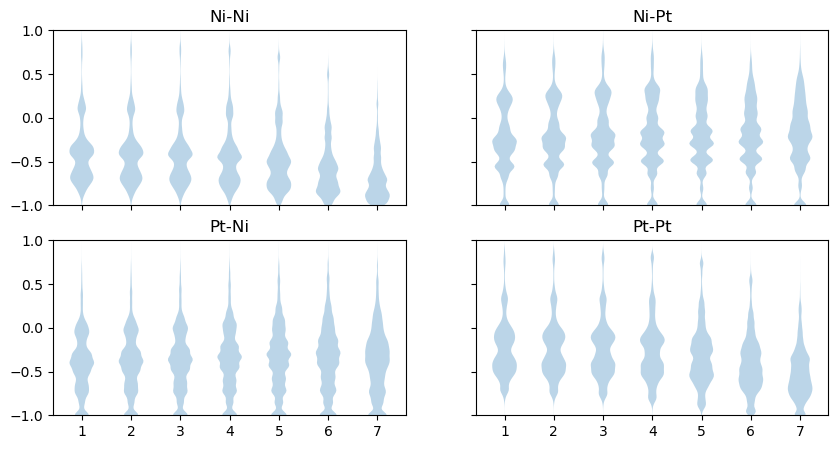

In [6]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, nrows=2, sharex=True, sharey=True)

axes[0, 0].violinplot(normalize(Gs_Ni[:, :7]), showextrema=False)
axes[0, 1].violinplot(normalize(Gs_Ni[:, 7:]), showextrema=False)
axes[1, 0].violinplot(normalize(Gs_Pt[:, :7]), showextrema=False)
axes[1, 1].violinplot(normalize(Gs_Pt[:, 7:]), showextrema=False)

axes[0, 0].set_title("Ni-Ni")
axes[0, 1].set_title("Ni-Pt")
axes[1, 0].set_title("Pt-Ni")
axes[1, 1].set_title("Pt-Pt")

axes[0, 0].set_ylim(-1, 1)